# Shapely Values

SHAP (SHapley Additive exPlanations)

* The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. 
* The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. * 
* The Shapley value is the average marginal contribution of a feature value across all possible coalitions. 
* The Shapley value is the average contribution of a feature value to the prediction in different coalitions. The Shapley value is NOT the difference in prediction when we would remove the feature from the model.


In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/My Drive/TATA/data"
model_path = "/content/drive/My Drive/TATA/data/models"

In [ ]:
! pip install shap

     |████████████████████████████████| 327kB 6.9MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456452 sha256=c84c5a8dc7778063e1c834d1f77d0b319d989a324ff8aaf75a694a8ccd1e8dfd
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [ ]:
# Import needed libraries
import sys
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import seaborn as sns
import itertools
from decimal import *

import xgboost
import shap

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv2D, Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf
from sklearn.preprocessing import normalize

In [ ]:
# load CNN model parameters
model = keras.models.load_model(os.path.join(model_path, 'cnn_RM_v11_QRT_1.h5'))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 27, 11, 7)         270       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2079)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2079)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                22869     
Total params: 23,139
Trainable params: 23,139
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# load features and target values
features = np.load(os.path.join(data_path, 'coilfeatures_v7_6.npy'), allow_pickle=True, fix_imports=True, encoding='latin1')[:, 1:]

targets = np.load(os.path.join(data_path, 'coiltargets_v7_6.npy'))

for f in range(features.shape[0]):
    features[f, 3] = float(features[f, 3])
    
features = features.astype(np.float64)

In [ ]:
# load and create labels for features
labels = np.load(os.path.join(data_path, "featurelabels_real.npy"),
                 allow_pickle = True, 
                 fix_imports=True,
                 encoding='latin1').item()

feature_labels = np.load(os.path.join(data_path, "featurelabels_v7.npy"), 
                         fix_imports=True, 
                         encoding='latin1')[1:]

feature_labels_new = []

for f in feature_labels:
    f = f.decode('utf-8')
    if (f in labels.keys()):
        rn = labels[f].replace(" ", "_")
        feature_labels_new.append(rn)
    else:
        feature_labels_new.append(f.replace(" ", "_"))

In [ ]:
# normalize features
features = normalize(np.nan_to_num(features), 
                    norm='l2', 
                    axis=0, 
                    copy=True, 
                    return_norm=False)

In [ ]:
# load CNN model parameters
model = keras.models.load_model(os.path.join(model_path, 'dnn_v1_hgroup_6.h5'))

In [ ]:
# feed features to the model and evaluate the predictions
train_data = np.expand_dims(features, axis=1)
y = model.predict(train_data)

# number of features
features_n = train_data.shape[-1]

# delete features array
del features

In [ ]:

# reshape train_data and prediction to 2 dimenstional arrays
train_data = np.reshape(train_data, (-1, features_n))
y = np.reshape(y, (-1, 1))

In [ ]:
n_samples = 10

# select a set of random set samples to take an expectation over
data_for_prediction = train_data[np.random.choice(train_data.shape[0], 
                                                  n_samples, replace=False)]

# explain predictions of the model on the selected samples 
explainer = shap.DeepExplainer(model, data_for_prediction)

# evaluate SHAP values for the set of random samples
shap_values = explainer.shap_values(data_for_prediction)

# expected value from the tensor
expected_value = tf.keras.backend.get_value(explainer.expected_value)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


keras is no longer supported, please use tf.keras instead.


In [ ]:
# make dataframes from random samples
df1 = pd.DataFrame(data_for_prediction, columns=feature_labels_new)
df2 = pd.DataFrame(data_for_prediction, columns=['F {}'.format(i) for i in range(1, features_n+1)])

In [ ]:
# load JS visualization code to notebook
shap.initjs()

# sample number to plot its shap values
sample_number = 1

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(expected_value, shap_values[0][sample_number], df2.iloc[sample_number])

Figure 1: Local shapley (shows the shap value for each sample)
* model base value = the average model output over the entire training dataset 
* model output = the output of model for the specific input sample.

Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue


We predicted 0.00 for the output of the above sample, whereas the base_value is 0.000001545. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from feature $F_5$. Though feature $F_{309}$ value has a meaningful effect decreasing the prediction.

If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output.

There is some complexity to the technique, to ensure that the baseline plus the sum of individual effects adds up to the prediction (which isn't as straightforward as it sounds).


In [ ]:
# load JS visualization code to notebook
shap.initjs()

# visualize the training set predictions
shap.force_plot(expected_value, shap_values[0], df2, link='logit')

Figure 2: global shapley (show the average importance of each feature)
*if we rotate figure 1 by 90 degrees plot it for all features and all samples and stack them horizontally, we can see the explanation over all examples in the dataset*
* x-axis : sample order by similarity**
* y-axis : model output value**
* Stacked SHAP explanations clustered by explanation similarity. Each position on the x-axis is an instance of the data. Red SHAP values increase the prediction, blue values decrease it.**

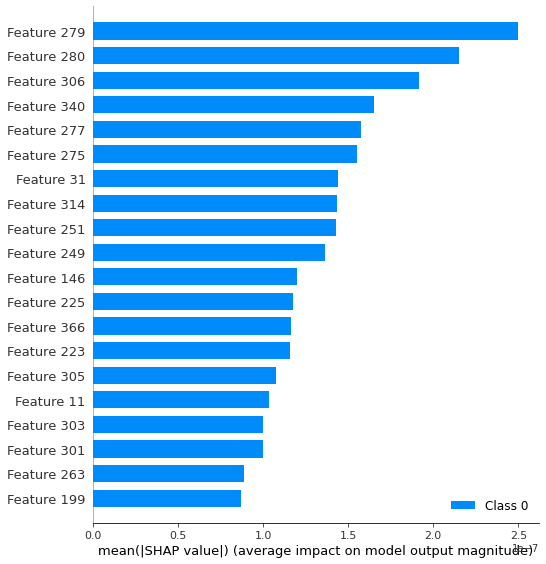

In [ ]:
shap.summary_plot(shap_values, train_data, plot_type="bar")

Figure 3. **Summary bar plot**. It shows the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs)

In [ ]:
df2.head()

,F 1,F 2,F 3,F 4,F 5,F 6,F 7,F 8,F 9,F 10,F 11,F 12,F 13,F 14,F 15,F 16,F 17,F 18,F 19,F 20,F 21,F 22,F 23,F 24,F 25,F 26,F 27,F 28,F 29,F 30,F 31,F 32,F 33,F 34,F 35,F 36,F 37,F 38,F 39,F 40,...,F 330,F 331,F 332,F 333,F 334,F 335,F 336,F 337,F 338,F 339,F 340,F 341,F 342,F 343,F 344,F 345,F 346,F 347,F 348,F 349,F 350,F 351,F 352,F 353,F 354,F 355,F 356,F 357,F 358,F 359,F 360,F 361,F 362,F 363,F 364,F 365,F 366,F 367,F 368,F 369
0,0.000034,0.002278,0.002260,0.002014,-0.001574,-0.000295,0.001706,0.001246,0.002708,0.001292,-0.002118,0.005283,0.001588,0.000083,0.001063,0.000000,0.000000,0.000473,0.000137,0.000202,0.003633,0.0,0.002148,0.000000,0.002186,0.000250,0.002306,0.000087,0.002326,0.000081,0.000874,0.001707,0.002247,0.000317,0.002214,0.001263,0.002493,0.000881,0.000227,0.003372,...,0.004957,0.002170,0.001668,0.001240,0.000265,0.000388,0.000005,0.002136,0.001090,0.002252,0.001862,0.000791,0.005313,0.002203,0.003129,0.001532,0.003063,0.001516,0.0,0.000000,0.0,0.002426,0.0,0.002495,0.001939,0.002159,0.001920,0.002160,0.000691,0.000317,0.000160,0.000091,0.000004,0.002136,0.000317,0.002245,0.005854,0.006594,0.003461,0.002215
1,0.000103,0.001139,0.002223,0.001883,-0.000446,-0.000295,0.002214,0.001297,0.001507,0.001064,-0.001653,0.005926,0.002261,0.000080,0.001064,0.000000,0.000000,0.000542,0.000133,0.000118,0.003624,0.0,0.002137,0.000003,0.002058,0.001106,0.002263,0.001098,0.002268,0.000226,0.000896,0.013470,0.002521,0.008110,0.002390,0.002869,0.001599,0.002323,0.002428,0.002714,...,0.000656,0.002120,0.001029,0.001289,0.000307,0.000142,0.002173,0.001934,0.000159,0.002190,0.005999,0.006868,0.001486,0.002069,0.000763,0.001743,0.000753,0.001743,0.0,0.004327,0.0,0.002426,0.0,0.002495,0.000971,0.002113,0.001125,0.002111,0.000399,0.000934,0.004973,-0.002818,0.002722,0.002455,0.004905,0.001921,0.006994,0.002937,0.000842,0.002069
2,0.002760,0.001139,0.002176,0.002067,0.000698,-0.002063,0.002023,0.000206,0.002034,0.001031,0.000775,0.000347,0.002325,0.000396,0.002262,0.000456,0.002079,0.000282,0.000117,0.000148,0.003165,0.0,0.002172,0.000003,0.002248,0.000063,0.002130,0.000081,0.002121,0.000062,0.000320,0.000335,0.002372,0.002108,0.002434,0.000419,0.002197,0.001340,-0.002783,0.000101,...,0.000467,0.002149,0.001175,0.000916,0.000201,0.000251,0.000004,0.002137,0.000072,0.002205,0.003409,0.002174,0.003138,0.002260,0.004403,0.002096,0.004407,0.002103,0.0,0.004327,0.0,0.002426,0.0,0.002495,0.000036,0.002136,0.000103,0.002135,0.000996,0.000907,0.000157,0.000225,0.000336,0.002184,0.000240,0.002187,0.003240,0.002507,0.001186,0.002261
3,0.000621,0.002278,0.001856,0.001924,-0.000975,-0.000884,0.001964,0.000265,0.001932,0.000738,-0.000850,0.000179,0.002197,0.000746,0.002254,0.002263,0.002170,0.003071,0.000101,0.007286,0.000614,0.0,0.002124,0.000000,0.002098,0.009624,0.002293,0.009789,0.002314,0.012699,0.008294,0.007536,0.002204,0.003399,0.001999,0.000872,0.002041,0.001540,-0.000517,0.000034,...,0.000134,0.002162,0.000712,0.000840,0.000095,0.000249,0.002076,0.001901,0.000210,0.002212,0.000256,-0.002498,0.001570,0.002106,0.002728,0.002094,0.002705,0.002082,0.0,0.000000,0.0,0.002426,0.0,0.002495,0.000869,0.002171,0.000869,0.002172,0.000088,0.001086,0.000056,0.000288,0.001149,0.002015,0.000271,0.002235,0.003323,-0.000219,0.000962,0.002106
4,0.000724,0.001139,0.002139,0.001365,-0.002104,-0.001179,0.001883,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


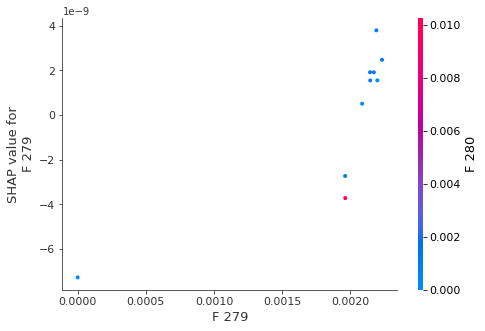

In [ ]:
# make plot.
shap.dependence_plot('F 279', shap_values[0], df2, interaction_index="F 280")

Figure 4. **Dependence plot**. To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset.Shap values represent a feature's responsibity for a change in model output. Vertical dispersion shows the interaction effect with other features. So the dependence plot helps understanding the impact of interaction between two features on model output. 

In [ ]:
from keras.applications.vgg16 import preprocess_input
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
model = clf
e = shap.GradientExplainer(
    (model.input, model.output),
    map2layer(td, 1),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
